In [1]:
import ginsim
import biolqm

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

cmp = sns.diverging_palette(0, 255, as_cmap=True)

# Load the model

First we load the model and the list of output components, and a set of 8 pre-defined input conditions.

In [2]:
lrg = ginsim.load("Interferon_stable_additions.zginml")
m = ginsim.to_biolqm(lrg)

outputs = (
    "Proinflammatory_cytokine_expression_Inflammation_phenotype",
    "type_I_IFN_response_phenotype",
    "ISG_expression_antiviral_response_phenotype",
    "Viral_replication_phenotype",   
)

inits = pd.read_csv("init.tsv", sep="\t", index_col=0)
dic_inits = inits.to_dict()
inits

C1  C2  C3  C4  C5  C6  C7  C8
viral_components    1   1   0   1   1   1   1   1
immune_response     0   0   1   1   1   1   1   1
IFN_secretion       1   1   1   1   0   1   1   1
Azithromycin_drug   1   0   0   1   0   0   0   0
GRL0617_drug        1   0   0   0   0   0   1   0
MNS_drug            1   0   0   0   0   0   0   1

<AxesSubplot:>

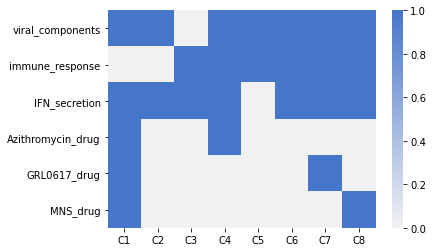

In [3]:
sns.heatmap(inits, cmap=cmp, center=0)

# Identification of all attractors

Here we search for all attractors (stable states and trap spaces) independently of the initial condition.
To summarize, we group together the attractors which share the same values of output components.

In [4]:
stables = biolqm.states_to_dataframe( biolqm.stable(m, autoconvert=False) )
traps = biolqm.trapspaces(m, autoconvert=False)

print( "The model has %s stable states and %s terminal trapspaces." % (len(stables), len(traps)) )

print("\nStable states projected on the output components:")
stables_proj = biolqm.states_to_dataframe( biolqm.stable(m, autoconvert=False).project_on_components(outputs) ).transpose()
stables_proj

The model has 128 stable states and 128 terminal trapspaces.

Stable states projected on the output components:


0  1  2  3  4  5
ISG_expression_antiviral_response_phenotype         1  0  1  0  1  1
Viral_replication_phenotype                         0  1  1  1  1  0
Proinflammatory_cytokine_expression_Inflammatio...  0  0  0  1  1  1
type_I_IFN_response_phenotype                       0  0  0  0  0  0

<AxesSubplot:>

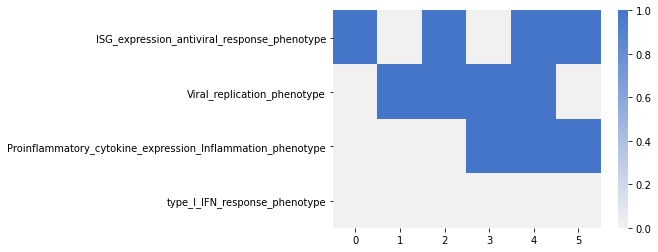

In [5]:
sns.heatmap(stables_proj, cmap=cmp, center=0)

# Attractors for the selected inputs

For each selected input condition, we have a single attractor (after projection on the outputs)

In [6]:
def apply_init(m, init):
    prt = " ".join([ "%s%%%s" % (i,v) for (i,v) in init.items() ])
    m1 = biolqm.perturbation(m, prt)
    traps = biolqm.trapspaces(m1, autoconvert=False).project_on_components(outputs)
    return biolqm.states_to_dataframe(traps)

data = [ apply_init(m, value) for value in dic_inits.values() ]
stable_inputs = pd.concat(data, keys=[name for name in dic_inits]).transpose()
stable_inputs

C1 C2 C3 C4 C5 C6 C7 C8
                                                    0  0  0  0  0  0  0  0
ISG_expression_antiviral_response_phenotype         1  0  1  1  0  0  0  0
Viral_replication_phenotype                         1  1  0  1  1  1  1  1
Proinflammatory_cytokine_expression_Inflammatio...  0  1  0  1  1  1  1  0
type_I_IFN_response_phenotype                       0  0  0  0  0  0  0  0

<AxesSubplot:xlabel='None-None'>

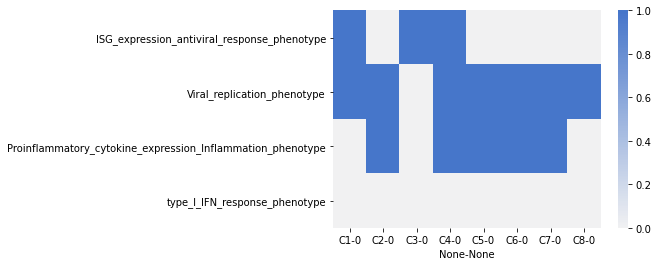

In [7]:
sns.heatmap(stable_inputs, cmap=cmp, center=0)

# Input propagation

We show that the input condition strongly controls the whole network and fully controls the output components.

In [8]:
# Transforms a dictionary into a dash-like pattern used for space restrictions.
# If a model has 4 components A, B, C, D in this order,
#  {A:0, D:1} => "0--1"
def dash_pattern(model, dict_vals):
    specific_comps = dict_vals.keys()
    str_pattern = ""
    for comp in model.getComponents():
        if comp.toString() in specific_comps:
            str_pattern += str(dict_vals.get(comp.toString()))
        else :
            str_pattern += "-"
    return(str_pattern)

def restrict_model(model, **dict_vals):
    pattern = dash_pattern(model, dict_vals)
    return biolqm.restrict(model, pattern)

def fill_fixed(data, names, functions, mddman):
    all_values = [f for f in functions]
    for comp, func in zip(names, functions):
        if mddman.isleaf(func): data[comp] = func
        else: data[comp] = -1
    

def get_fixed_pattern(all_names, model, as_dict=False):
    # Build a container for the results
    pattern = {key: 100 for key in all_names}
    
    # Model manager and core components
    mddman = model.getMDDManager()
    core_components = [node.getNodeID() for node in model.getComponents()]
    extra_components = [node.getNodeID() for node in model.getExtraComponents()]
    
    # 1/ Non-extra values: if the model was not reduced, core components may also contain fixed values
    fill_fixed(pattern, core_components, model.getLogicalFunctions(), mddman)

    # Special value for input components
    for node in model.getComponents():
        if node.isInput():
            pattern[node.getNodeID()] = -2

    
    # 2/ Extra values : only available after reduction/percolation
    # Functions of each component
    fill_fixed(pattern, extra_components, model.getExtraLogicalFunctions(), mddman)

    if as_dict: return pattern
    return pd.Series(pattern, dtype=np.byte)

def get_fixed(gs_model, restricted_model, as_dict=False):
    name_components = [ n.getId() for n in gs_model.getNodeOrder() ]
    return get_fixed_pattern(name_components, restricted_model, as_dict)

def show_fixed(gs_model, styler, fixed_pattern, save=None):
    styler.setState(fixed_pattern.values.tobytes())
    return ginsim.show(gs_model, style=styler, save=save)


# Define color mapping rules
styler_fixed = ginsim.lrg_style(lrg)
styler_fixed.mapState2Color(0, 255, 255, 255)
styler_fixed.mapState2Color(1, 100, 100, 255)
styler_fixed.mapState2Color(-1, 255, 100, 100)

In [9]:
data = []
for init_name, values in dic_inits.items():
    lqm_model_restricted = restrict_model(m, **values)
    data.append( get_fixed(lrg, lqm_model_restricted) )
df = pd.concat(data, axis=1, keys=[name for name in dic_inits])

The result of input propagation can be visualized in the following heatmap where lines represent components of the system and columns represent the 8 selected input conditions.
A white cell denotes that the corresponding component is fixed at value 0 in this input condition. Likewise, a blue cell denotes that it is fixed at 1. Red cells denote components which are not fixed by input propagation.

<AxesSubplot:>

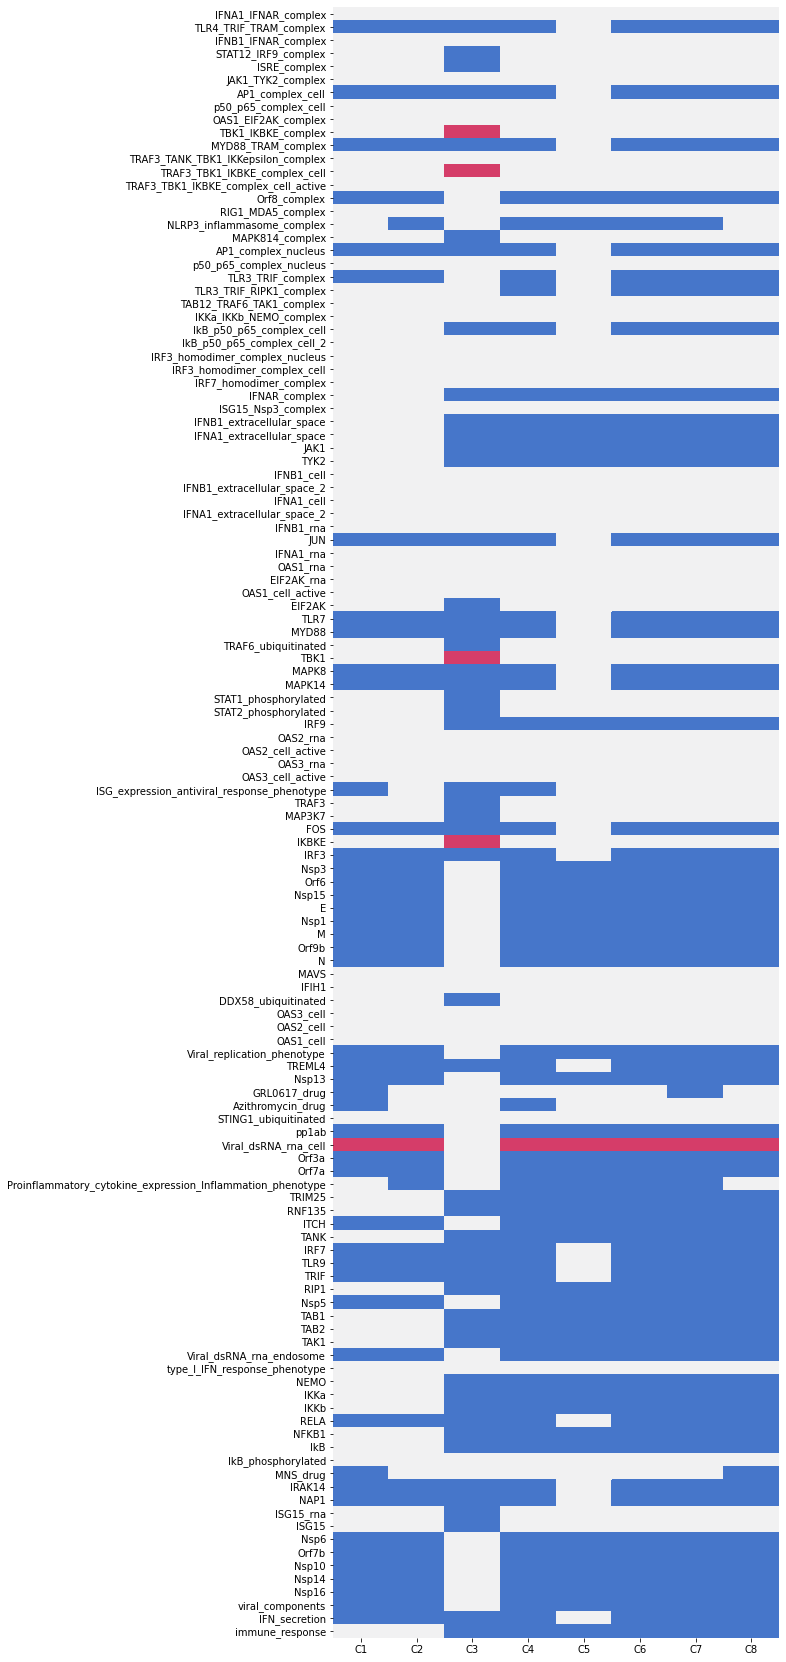

In [10]:
plt.figure(figsize=(8,30))
sns.heatmap(df, center=0, cmap=cmp, cbar=False)

Here we restrict this result to the input and output components.

In [11]:
selected_rows = tuple( [i for i in inits.index.values] + [i for i in outputs] )
df_proj = pd.DataFrame(df, index=selected_rows)
df_proj

C1  C2  C3  C4  C5  C6  \
viral_components                                     1   1   0   1   1   1   
immune_response                                      0   0   1   1   1   1   
IFN_secretion                                        1   1   1   1   0   1   
Azithromycin_drug                                    1   0   0   1   0   0   
GRL0617_drug                                         1   0   0   0   0   0   
MNS_drug                                             1   0   0   0   0   0   
Proinflammatory_cytokine_expression_Inflammatio...   0   1   0   1   1   1   
type_I_IFN_response_phenotype                        0   0   0   0   0   0   
ISG_expression_antiviral_response_phenotype          1   0   1   1   0   0   
Viral_replication_phenotype                          1   1   0   1   1   1   

                                                    C7  C8  
viral_components                                     1   1  
immune_response                                      1   1  
IFN_secretion                                        1   1  
Azithromycin_drug                                    0   0  
GRL0617_drug                                         1   0  
MNS_drug                                             0   1  
Proinflammatory_cytokine_expression_Inflammatio...   1   0  
type_I_IFN_response_phenotype                        0   0  
ISG_expression_antiviral_response_phenotype          0   0  
Viral_replication_phenotype                          1   1

<AxesSubplot:>

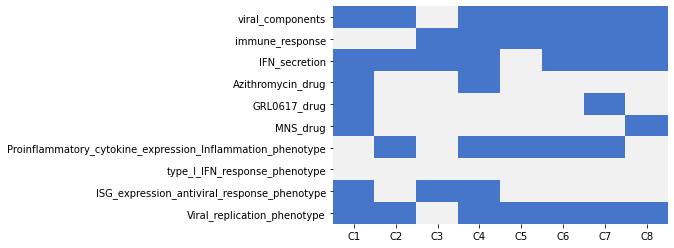

In [12]:
sns.heatmap(df_proj, center=0, cmap=cmp, cbar=False)

Propagated inputs for a specific input condition can also be mapped on the regulatory graph using the same color code (white for fixed at 0, blue for fixed at 1, and red for components which are not fixed).

In [13]:
fixed = data[1]
show_fixed(lrg, styler_fixed, fixed)